<a href="https://colab.research.google.com/github/aqwvinh/Basic_guideline_for_Machine_Learning/blob/master/Real_disaster_%3F_(Bin_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### We will implement 3 methods. Decreasing order of performance:
- Word2Vec using a pipeline using Log Reg and SVC
- TF-IDF with basic ML algorithms
- GloVe for LSTM

### Importation

In [1]:
# For Word2Vec. Download this first, then once downloaded, restart the environment and comment this line. 
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=36d1d8fadcd809ce66a0b19d586ab0ddc8d3367aaa29602a90c366079b921617
  Stored in directory: /tmp/pip-ephem-wheel-cache-d7xpwvrl/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

## For Word2Vec
# import spacy for NLP and re for regular expressions
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
# import sklearn transformers, models and pipelines
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
# Load the small language model from spacy
nlp = spacy.load('en_core_web_sm')
# set pandas text output to 400
pd.options.display.max_colwidth = 400


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model, metrics, svm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "vinhnguyen94" # username from the json file
os.environ['KAGGLE_KEY'] = "2c4c2798fb6e7254b642c13f8548dafa" # key from the json file
!kaggle competitions download -c nlp-getting-started # api copied from kaggle. Get the API on the address link

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 10.5MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.3MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.8MB/s]


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

### Data understanding

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [7]:
# To see how many unique values in a column
cols = ["id","keyword", "location", "text"]
for col in cols:
  print(train[cols].nunique())

id          7613
keyword      221
location    3341
text        7503
dtype: int64
id          7613
keyword      221
location    3341
text        7503
dtype: int64
id          7613
keyword      221
location    3341
text        7503
dtype: int64
id          7613
keyword      221
location    3341
text        7503
dtype: int64


In [8]:
len(train) - train.count()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
len(test)-test.count()

id             0
keyword       26
location    1105
text           0
dtype: int64

Observations: 
- It seems to have some duplicates in text
- Lots of missing values for keyword and location, as explained by the data description
- Some texts are differently labeled

Decisions:
- Investigate further and delete the true duplicates
- Fill the blank with "Unknown"
- Create a corrected target_relabeled variable 

In [10]:
# Duplicates
df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [0]:
train['target_relabeled'] = train['target'].copy() 

train.loc[train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train.loc[train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train.loc[train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train.loc[train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train.loc[train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train.loc[train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train.loc[train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
train.loc[train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
train.loc[train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train.loc[train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train.loc[train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train.loc[train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train.loc[train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train.loc[train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train.loc[train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train.loc[train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train.loc[train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train.loc[train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

Missing values

In [0]:
# Create a combined list to treat missing values once
combine = [train, test]

In [0]:
for set in combine:
  set[["keyword", "location"]] = set[["keyword", "location"]].fillna("Unknown")

In [14]:
len(train) - train.count()

id                  0
keyword             0
location            0
text                0
target              0
target_relabeled    0
dtype: int64

In [15]:
len(test) - test.count()

id          0
keyword     0
location    0
text        0
dtype: int64

No more missing values

### Data cleaning

In [33]:
# To keep the train and test separation
ntrain = train.shape[0]
ntest = test.shape[0]
ntrain, ntest

(7613, 3263)

Remove URL

In [16]:
# Create a concatenated df to clean data once
df = pd.concat([train,test])
df.shape

(10876, 6)

In [0]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

Remove HTML Tags

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
df['text']=df['text'].apply(lambda x : remove_html(x))

Remove Emojis

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
df['text']=df['text'].apply(lambda x : remove_emoji(x))

Low cases

In [0]:
import string
df['text']=df['text'].apply(lambda x : x.lower())

Remove punctuation

In [0]:
import string

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [37]:
# Resplit the processed train and test sets
train = df[:ntrain]
test = df[ntrain:]
train.shape, test.shape

((7613, 6), (3263, 6))

In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train.target_relabeled = encoder.fit_transform(train.target_relabeled)
train

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,keyword,location,text,target,target_relabeled
0,1,Unknown,Unknown,our deeds are the reason of this earthquake may allah forgive us all,1.0,1
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1.0,1
2,5,Unknown,Unknown,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1.0,1
3,6,Unknown,Unknown,13000 people receive wildfires evacuation orders in california,1.0,1
4,7,Unknown,Unknown,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1.0,1
...,...,...,...,...,...,...
7608,10869,Unknown,Unknown,two giant cranes holding a bridge collapse into nearby homes,1.0,1
7609,10870,Unknown,Unknown,ariaahrary thetawniest the out of control wild fires in california even in the northern part of the state very troubling,1.0,1
7610,10871,Unknown,Unknown,m194 0104 utc5km s of volcano hawaii,1.0,1
7611,10872,Unknown,Unknown,police investigating after an ebike collided with a car in little portugal ebike rider suffered serious nonlife threatening injuries,1.0,1


### Word2Vec

In [46]:
# Load the en_core_web_lg model
nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser", "ner"])

# create train set by getting the document vector
docs_train = [nlp(doc).vector for doc in train.text]
X_train = np.vstack(docs_train)
print('Shape of train set: {}'.format(X_train.shape))

# create test set likewise
docs_test = [nlp(doc).vector for doc in test.text]
X_test = np.vstack(docs_test)
print('Shape of test set: {}'.format(X_test.shape))

# create target
y_train = train.target_relabeled.copy()

Shape of train set: (7613, 300)
Shape of test set: (3263, 300)


In [47]:
# create machine learning pipeline
word2vec_pipe = Pipeline([('estimator', LGBMClassifier())])

# cross validate
print('F1 score: {:.3f}'.format(np.mean(cross_val_score(word2vec_pipe, X_train, y_train, scoring = 'f1'))))

# fit pipeline
word2vec_pipe.fit(X_train, y_train)

# predict on test set
pred = word2vec_pipe.predict(X_test)

# submit prediction
sample_submission.target = pred
sample_submission.to_csv('word2vec_baseline.csv', index = False)

F1 score: 0.738


In [55]:
# create a parameter grid
param_grid = [{'estimator' : [LogisticRegression()], 
               'estimator__C' : np.logspace(-3, 3, 7)},
              {'estimator' : [SVC()], 
               'estimator__C' : np.logspace(-2, 2, 3), 
               'estimator__gamma' : np.logspace(-2, 2, 5) / X_train.shape[0]}]

# create a RandomizedSearchCV object
word2vec_grid_search = GridSearchCV(
    estimator = word2vec_pipe,
    param_grid = param_grid,
    scoring = 'f1',
    n_jobs = -1,
    refit = True,
    verbose = 1,
    return_train_score = True
)

# fit RandomizedSearchCV object
word2vec_grid_search.fit(X_train, y_train)

# print grid search results
cols = ['param_estimator',
        'param_estimator__C',
        'param_estimator__gamma',
        'mean_test_score',
        'mean_train_score']

pd.options.display.max_colwidth = 50

word2vec_grid_search_results = pd.DataFrame(word2vec_grid_search.cv_results_).sort_values(by = 'mean_test_score', 
                                                                                          ascending = False)
word2vec_grid_search_results[cols].head(10)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
# predict on test set with the best model from the randomized search
pred = word2vec_grid_search.predict(X_test)

# submit prediction
sample_submission.target = pred
sample_submission.to_csv('word2vec_tuned.csv', index = False)

### GloVe and LSTM

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop=stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [0]:
corpus=create_corpus(df)


100%|██████████| 10876/10876 [00:01<00:00, 6858.81it/s]


In [0]:
embedding_dict={}
with open('../glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

train_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [0]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [0]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 592277.48it/s]


In [0]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [0]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 2,076,670
Trainable params: 42,370
Non-trainable params: 2,034,300
_________________________________________________________________


In [0]:
train_LSTM=train_pad[:train.shape[0]]
test_LSTM=train_pad[train.shape[0]:]

In [0]:
X_train,X_valid,y_train,y_valid=train_test_split(train_LSTM,train['target_relabeled'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_valid.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [0]:
from keras.callbacks import EarlyStopping

# Fit on the training data
history = model.fit(x = X_train,y = y_train,batch_size=4,epochs=15, validation_data = (X_valid, y_valid),
                    callbacks=[EarlyStopping(monitor='val_loss', patience = 3)])

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 [==============================] - 167s 26ms/step - loss: 0.5621 - accuracy: 0.7393 - val_loss: 0.5100 - val_accuracy: 0.7706
Epoch 2/15
6471/6471 [==============================] - 172s 27ms/step - loss: 0.5600 - accuracy: 0.7404 - val_loss: 0.5063 - val_accuracy: 0.7732
Epoch 3/15
6471/6471 [==============================] - 174s 27ms/step - loss: 0.5588 - accuracy: 0.7433 - val_loss: 0.5037 - val_accuracy: 0.7741
Epoch 4/15
6471/6471 [==============================] - 171s 26ms/step - loss: 0.5477 - accuracy: 0.7483 - val_loss: 0.5007 - val_accuracy: 0.7758
Epoch 5/15
6471/6471 [==============================] - 163s 25ms/step - loss: 0.5468 - accuracy: 0.7514 - val_loss: 0.4992 - val_accuracy: 0.7776
Epoch 6/15
6471/6471 [==============================] - 164s 25ms/step - loss: 0.5464 - accuracy: 0.7557 - val_loss: 0.4976 - val_accuracy: 0.7793
Epoch 7/15
6471/6471 [==============================] - 170s 26ms/step

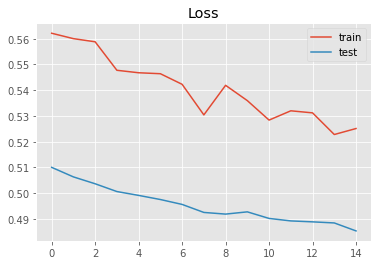

In [0]:
# Plot to monitor overfitting
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [0]:
y_pre=model.predict(test_LSTM)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':test['id'],'target':y_pre})
sub.to_csv('submission.csv',index=False)

print("Your submission was successfully saved!")

### TF-IDF

In [2]:
# Gather all texts in one column
train["token"] = train.text + " " + train.keyword + " " + train.location
train.token[0]

NameError: ignored

In [0]:
# Gather all texts in one column

test["token"] = test.text + " " + test.keyword + " " + test.location
test.token[0]

'Just happened a terrible car crash Unknown Unknown'

In [0]:
df_train = train.drop(["keyword", "location", "text"], axis = 1)
df_train

,id,target,target_relabeled,token
0,1,1,1,Our Deeds are the Reason of this #earthquake M...
1,4,1,1,Forest fire near La Ronge Sask. Canada Unknown...
2,5,1,1,All residents asked to 'shelter in place' are ...
3,6,1,1,"13,000 people receive #wildfires evacuation or..."
4,7,1,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
7608,10869,1,1,Two giant cranes holding a bridge collapse int...
7609,10870,1,1,@aria_ahrary @TheTawniest The out of control w...
7610,10871,1,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,1,1,Police investigating after an e-bike collided ...


In [0]:
df_test = test.drop(["keyword", "location", "text"], axis = 1)
df_test

,id,token
0,0,Just happened a terrible car crash Unknown Unk...
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires Unkno...
4,11,Typhoon Soudelor kills 28 in China and Taiwan ...
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Functions for preprocessing
def get_wordnet_pos(pos_tag):
    output = np.asarray(pos_tag)
    for i in range(len(pos_tag)):
        if pos_tag[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pos_tag[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pos_tag[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
    return output

def preprocessing_sentence(sentence):
    tokens = word_tokenize(sentence)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words("english")]
    words_tagged = nltk.pos_tag(tokens)
    tags = get_wordnet_pos(words_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = [lemmatizer.lemmatize(w_t[0], pos=w_t[1]) for w_t in tags]
    return lemmatized_sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
df_train.token = df_train.token.apply(preprocessing_sentence) # create a new column "token" with the preprocessed texts
df_train.head(2)

,id,target,target_relabeled,token
0,1,1,1,"[deed, reason, earthquake, may, allah, forgive..."
1,4,1,1,"[forest, fire, near, la, ronge, sask, canada, ..."


In [0]:
df_test.token = df_test.token.apply(preprocessing_sentence) # create a new column "token" with the preprocessed texts
df_test.head(2)

,id,token
0,0,"[happen, terrible, car, crash, unknown, unknown]"
1,2,"[heard, earthquake, different, city, stay, saf..."


In [0]:
# State clearly the X and y variables
X = df_train.token
y = df_train.target

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Initialize vectorizer with identity analyzer
vect = TfidfVectorizer(analyzer = lambda x: x, max_features = 3000)

#Get the tfidf (format in sparse matrix) to fit the model. fit_transform for train and transform for valid
X = vect.fit_transform(X)
#Display the tfidf_1gram:
pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

,ab,aba,abandon,abbswinston,abc,abcnews,abe,ability,ablaze,able,abortion,absolutely,abstorm,abuja,abuse,access,accident,accidentally,accord,account,accra,accuse,acre,across,act,action,activate,activates,active,activity,actual,actually,ad,add,address,adelaide,admits,adult,advance,adventure,...,wy,x,xbox,xd,xp,ya,yall,yay,yazidis,yea,yeah,year,yellow,yes,yesterday,yet,yo,yobe,yonews,york,yorker,yorkshire,young,youngheroesid,youth,youtube,yr,yrs,yyc,zayn,zealand,zero,zionist,zombie,zone,zouma,åá,åè,åê,ìït
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Creating the models
models = [LogisticRegression(random_state= 1), svm.SVC(random_state= 1), SGDClassifier(random_state= 1), GradientBoostingClassifier(random_state= 1), RandomForestClassifier(random_state= 1),
            XGBClassifier(random_state= 1), DecisionTreeClassifier(random_state= 1), BaggingClassifier(DecisionTreeClassifier(random_state=1)), LGBMClassifier(random_state= 1), AdaBoostClassifier(random_state= 1),
          KNeighborsClassifier()                                      
             ]
names = ['Logistic Regression','Support Vector Classifier','Stochastic Gradient Descent','Gradient Boosting Tree','Random Forest',
         'XGBoost', 'Decision Tree', 'Bagging Decision Tree', 'Light GBM', 'Adaboost', "KNN"
         ]

In [0]:
# Define an error function: F1
from sklearn.model_selection import KFold, cross_val_score
def f1(model, X, y):
    f1 = cross_val_score(model, X, y, scoring="f1", cv=5)
    return f1

In [0]:
# Perform 5-folds cross-validation to evaluate the models 
for model, name in zip(models, names):
    # F1 score
    score = f1(model, X, y)
    print(f"- {name}: Mean: {round(score.mean(),3)}, Std: {round(score.std(),3)}")

- Logistic Regression: Mean: 0.53, Std: 0.07
- Support Vector Classifier: Mean: 0.509, Std: 0.074
- Stochastic Gradient Descent: Mean: 0.559, Std: 0.069
- Gradient Boosting Tree: Mean: 0.388, Std: 0.089
- Random Forest: Mean: 0.509, Std: 0.064
- XGBoost: Mean: 0.396, Std: 0.089
- Decision Tree: Mean: 0.495, Std: 0.044
- Bagging Decision Tree: Mean: 0.485, Std: 0.047
- Light GBM: Mean: 0.506, Std: 0.087
- Adaboost: Mean: 0.435, Std: 0.084
- KNN: Mean: 0.477, Std: 0.071


In [0]:
# Gridsearch for log reg
from sklearn import model_selection
import math
param_grid = {
              "max_iter": [500]
            
                 
              } 
 
clf = model_selection.GridSearchCV(SGDClassifier(random_state= 1, alpha = 0.0001, loss = 'hinge', penalty = 'l2', n_iter_no_change= 100  ), param_grid = param_grid, scoring = "f1", cv = 5)
clf.fit(X, y)
print("The best parameters are: ",clf.best_params_)
print("The best score achieved is: ",clf.best_score_)

The best parameters are:  {'max_iter': 500}
The best score achieved is:  0.5611886332334413


In [0]:
# Predictions with the best model
best_model = SGDClassifier(alpha = 0.0001, loss = "hinge", penalty = "l2", n_iter_no_change= 100, max_iter = 500)
best_model.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=100, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
test.token = df_test.token.apply(preprocessing_sentence) # create a new column "tokens" with the preprocessed titles
test

,id,token
0,0,"[happen, terrible, car, crash, unknown, unknown]"
1,2,"[heard, earthquake, different, city, stay, saf..."
2,3,"[forest, fire, spot, pond, geese, flee, across..."
3,9,"[apocalypse, light, spokane, wildfire, unknown..."
4,11,"[typhoon, soudelor, kill, china, taiwan, unkno..."
...,...,...
3258,10861,"[earthquake, safety, los, angeles, safety, fas..."
3259,10865,"[storm, ri, bad, last, hurricane, hard, hit, y..."
3260,10868,"[green, line, derailment, chicago, unknown, un..."
3261,10874,"[meg, issue, hazardous, weather, outlook, hwo,..."


In [0]:
#Get tfidf for test set
X_test = vect.transform(test.token)

#Get predictions labels
y_pred = best_model.predict(X_test)

In [0]:
# Save predictions in format used for competition scoring
output = pd.DataFrame({'id': test["id"],
                       'target': y_pred})
output.to_csv('SGD opti.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


In [0]:
# Plot train Target
sns.countplot(y_pred)
plt.xlabel('Target')
plt.title('Target distribution')

NameError: ignored